<a href="https://colab.research.google.com/github/artie-nazarov/ASCAI-ML/blob/main/KNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Week 1: K-Nearest-Neighbor
#### by Rohan Pandey, Santa Cruz Artificial Intelligence

In case you haven't used one before, this is a Jupyter Notebook, basically an environment to run Python code interactively online. Open this notebook in the playground or make a copy to your own Google Drive to be able to run and edit. 

Once you've done so, you'll be able to click the "play" arrows to the left of each code box to run them, though it may take a while to connect to a server the first time around. We'll be using these notebooks for most code demos throughout the quarter.

We start by getting the Iris dataset from sklearn, a Python library. Let's take a look at the structure of this dataset.

In [ ]:
from sklearn.datasets import load_iris

iris = load_iris() # loads in the Iris dataset
print(iris.feature_names) # features (columns) of Iris
print(iris.data) # all datapoints (rows) of Iris
print(iris.target_names) # target (output) name columns of Iris
print(iris.target) # target labels of each row of Iris

['sepal length (cm)', 'sepal width (cm)', 'petal length (cm)', 'petal width (cm)']
[[5.1 3.5 1.4 0.2]
 [4.9 3.  1.4 0.2]
 [4.7 3.2 1.3 0.2]
 [4.6 3.1 1.5 0.2]
 [5.  3.6 1.4 0.2]
 [5.4 3.9 1.7 0.4]
 [4.6 3.4 1.4 0.3]
 [5.  3.4 1.5 0.2]
 [4.4 2.9 1.4 0.2]
 [4.9 3.1 1.5 0.1]
 [5.4 3.7 1.5 0.2]
 [4.8 3.4 1.6 0.2]
 [4.8 3.  1.4 0.1]
 [4.3 3.  1.1 0.1]
 [5.8 4.  1.2 0.2]
 [5.7 4.4 1.5 0.4]
 [5.4 3.9 1.3 0.4]
 [5.1 3.5 1.4 0.3]
 [5.7 3.8 1.7 0.3]
 [5.1 3.8 1.5 0.3]
 [5.4 3.4 1.7 0.2]
 [5.1 3.7 1.5 0.4]
 [4.6 3.6 1.  0.2]
 [5.1 3.3 1.7 0.5]
 [4.8 3.4 1.9 0.2]
 [5.  3.  1.6 0.2]
 [5.  3.4 1.6 0.4]
 [5.2 3.5 1.5 0.2]
 [5.2 3.4 1.4 0.2]
 [4.7 3.2 1.6 0.2]
 [4.8 3.1 1.6 0.2]
 [5.4 3.4 1.5 0.4]
 [5.2 4.1 1.5 0.1]
 [5.5 4.2 1.4 0.2]
 [4.9 3.1 1.5 0.2]
 [5.  3.2 1.2 0.2]
 [5.5 3.5 1.3 0.2]
 [4.9 3.6 1.4 0.1]
 [4.4 3.  1.3 0.2]
 [5.1 3.4 1.5 0.2]
 [5.  3.5 1.3 0.3]
 [4.5 2.3 1.3 0.3]
 [4.4 3.2 1.3 0.2]
 [5.  3.5 1.6 0.6]
 [5.1 3.8 1.9 0.4]
 [4.8 3.  1.4 0.3]
 [5.1 3.8 1.6 0.2]
 [4.6 3.2 1.4 0.2]
 [5.3

# Simple Overview Version

Now we'll split it into training and testing batches with an 80% to 20% ratio. Btw, check out what happens when you play with random_state. The $x$ batches contain the features/input datapoints (petal width, sepal length, etc) while the $y$ batches contain the corresponding targets/output (setosa, versicolor, virginica). 

Then we iterate through values of $k$ 1 - 40 and for each iteration, train a model using that $k$ value on the training batches. We'll then make predictions on the $x$ testing batch and compare the predicted output to the true outputs, i.e. the $y$ testing batch. This comparison will be stored as an error percentage for each value of $k$.

After iterating through all $k$, we can find the value that produced the minimum error. We'll also plot the $k$ values against the error they produced just as a visualization.

Optimal k value: 8


Text(0, 0.5, 'Error %')

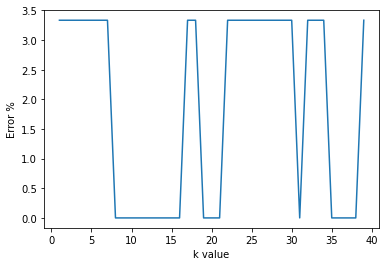

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics
import matplotlib.pyplot as plt

x_train, x_test, y_train, y_test = train_test_split(iris.data, iris.target, test_size=0.2, random_state=0)
errors = {}

for k in range(1, 40):
        knn = KNeighborsClassifier(n_neighbors=k).fit(x_train,y_train)
        y_pred = knn.predict(x_test)
        errors[k] = (1 - metrics.accuracy_score(y_test,y_pred)) * 100


minErr = min(errors.items(), key=lambda x: x[1])
print('Optimal k value:', minErr[0])

plt.plot(list(errors.keys()), list(errors.values()))
plt.xlabel('k value')
plt.ylabel('Error %')

# Building it from Scratch Version

That was a good overview, but it didn't really show you the inner workings of the KNN model; we were just passing it parameters and it did the learning internally. Now we will build the model from start to finish. Let's start by writing some of the helper functions we know that we'll need.

The first function is a Euclidean Distance function. This will allow us to calculate the distance between two points in space, which is needed if we want to find the nearest neighbors.

The second function is a "voting" function. Once we've found our k number of nearest neighbors, we'll need to find which value occurs the most in it, which this vote will determine.

In [ ]:
# calculates standard Euclidean Distance between 2 points
def euclideanDistance(p1, p2):
    distance = 0
    for x in range(len(p1)):
        distance += (p1[x] - p2[x]) ** 2
    return distance ** 1/2 # sqrt

# finds the value in an array with the most occurrences
def vote(arr):
  count = {} # dict of {val: occurrenceNum}
  for i in arr:
    if i not in count:
      count[i] = 0
    count[i] += 1
  highest = max(count.items(), key=lambda x: x[1]) # maximizes occurenceNum
  return highest[0] # returns only val

Now we'll get into writing the actual KNN model. 

This first function $testK$, will determine the total error percentage given a value of $k$ and a dataset to test it on. We'll use it in both training and testing our model. This function iterates through every point, finds its $k$ nearest neighbors, and determines whether the neighbors' vote was correct. If the prediction was wrong, it'll increment the error by 1. After going through all the datapoints, it returns the total error percentage.

The next function $trainKnn$ is actually quite simple and closely parallels the simple sklearn model we wrote at the start. It iterates through 40 values of $k$ and tests each one, building a list of the errors which it plots. It then finds and returns the $k$ resulting in the minimum error.

Note that both models take a distance metric function that defaults to the euclideanDistance function we wrote earlier. We'll come back to this later.

In [ ]:
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

# tests a k value by iterating through data
def testK(data, targets, k, distanceMetric=euclideanDistance):
  k_error = 0 # error for each k starts at 0
  for i in range(len(data)): # first datapoint iteration
    dists = [] # distances between datapoints i and j
    for j in range(i + 1, len(data)): # second datapoint iteration
      dist = (distanceMetric(data[i], data[j]), targets[j]) # (distance, target)
      dists.append(dist)

    if len(dists) < k: # breaks out of loop if too few data left
      break

    dists = sorted(dists, key=lambda x: x[0]) # sorts by nearest distance
    nearest = dists[0:k] # k nearest neighboring datapoints
    nearest_targets = [val[1] for val in nearest] # extracts nearest targets

    if targets[i] != vote(nearest_targets): # compares actual target and vote
      k_error += 1 # increments error if vote predicts incorrectly
      
  return k_error / len(data)

# finds the optimum k value from training data and targets
def trainKnn(data, targets, distanceMetric=euclideanDistance):
  error = [] # arr of error for each k val
  for k in range(1, 40):
    k_error = testK(data, targets, k, distanceMetric) # tests specific k value
    error.append((k, k_error)) # (k value, error percent)

  # plotting error of model with respect to k
  plt.xlabel('k value')
  plt.ylabel('error percent')
  plt.plot([i[0] for i in error], [i[1] * 100 for i in error])

  # print('err:', error) # print error for all k
  min_error = min(error, key=lambda x: x[1]) # minimize error
  return min_error[0] # minimum error k value

Below, we split the Iris dataset into batches and train a model, find a $k$, and then test that value on the testing batch. As you can see, our results are different, and worse, than sklearn's built in model. What are some reasons you think this may be?

Optimal k value: 3
test error: 0.16666666666666666


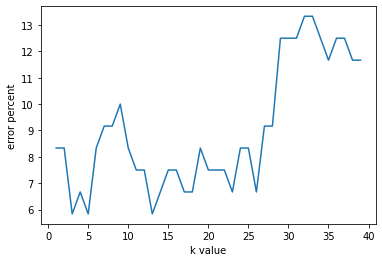

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(iris.data, iris.target, test_size=0.2, random_state=0)
k = trainKnn(x_train, y_train)
print('Optimal k value:', k)
err = testK(x_test, y_test, k) # testK can also now be used to test the model
print('test error:', err)

This idea of finding the parameter(s) that result in minimum error is at the foundation of Machine Learning, and even though the model may vary largely, the process we just went through remains more or less the same for most of ML.

In ML, we also have "hyperparameters" which are parameters that the model doesn't learn, but rather we tune ourselves to produce the best results. The main hyperparameter for KNN would be the distance metric function, but you could hyperparametrize other things like the number of $k$ values to test as well.

Take a few minutes to write another distance metric function. Then train and test a model using that function to judge which metric works best.

92
Optimal k value: 39
test error: 0.0


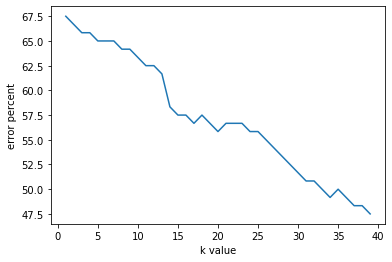

In [ ]:
# define this function using Manhattan, Cosine, or any other distance function you like
# p1, p2 are going to be lists of points p1 = [2, 3, 4, 6 ...]
def myDistance(p1, p2):
  pass

def manhattan(p1, p2):
  distance = 0
  for x in range(len(p1)):
    distance += abs(p1[x] - p2[x])
  return distance 

def cosine(p1, p2):
  mults = []

  for i in range(len(p1)):
    mults.append(p1[i] * p2[i])
  
  mySum = 0
  for i in mults:
    mySum += i

  return mySum

print(manhattan([32, 54], [-1, -5, 1]))

# now train and test a model using your distance function
x_train, x_test, y_train, y_test = train_test_split(iris.data, iris.target, test_size=0.2, random_state=0)
k = trainKnn(x_train, y_train, distanceMetric=cosine)
print('Optimal k value:', k)
err = testK(x_test, y_test, k) # testK can also now be used to test the model
print('test error:', err)

Congratulations, you just built your first Machine Learning model and tuned a hyperparameter!